In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, f1_score
random_seed=2025


# Case1

1. raw data 모든 컬럼(int,float형 데이터) 사용 (이상치 제거X)
2. 라벨 인코딩

## Data Load

- train set -> train, val
    - model훈련 -> train 
    - model평가 -> val 

최종 model 선택 후 
- val set -> test set.
    - model최종평가 -> test

In [2]:
# train data
label_path = "./data/train/label/"
raw_path = "./data/train/raw/"

train_label = pd.read_csv(label_path+"1.걸음걸이/training_label.csv")
train_activity = pd.read_csv(raw_path+'train_activity.csv')
train_sleep = pd.read_csv(raw_path+'train_sleep.csv')

# validation -> test data
label_path = "./data/validation/label/"
raw_path = "./data/validation/raw/"

test_label = pd.read_csv(label_path+"1.걸음걸이/val_label.csv")
test_activity = pd.read_csv(raw_path+'val_activity.csv')
test_sleep = pd.read_csv(raw_path+'val_sleep.csv')

In [3]:
def merge_split(df1, df2, label):
    '''
    기능: 1. activity,sleep concat
         2. label merge
    '''
    df = pd.concat([df1, df2.drop('EMAIL',axis=1)], axis=1)
    label.rename(columns={"SAMPLE_EMAIL": "EMAIL"}, inplace=True)
    df = df.merge(label, how='inner', on="EMAIL")

    y = df.iloc[:,-1]
    X = df.select_dtypes(include=[int, float])

    print('X:{}'.format(X.shape))
    print('y:{}'.format(y.shape))

    return X, y

In [4]:
X, y = merge_split(train_activity, train_sleep, train_label)

X:(9705, 51)
y:(9705,)


In [5]:
# 라벨 인코딩
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.transform(y) 

In [6]:
label_encoder.classes_ # 알파벳 순으로 정렬 후 변환 CN, Dem, MCI

array(['CN', 'Dem', 'MCI'], dtype=object)

In [7]:
# 데이터 스케일링
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [8]:
# split train, val (test는 이미 있으므로)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y,
                                                  test_size = 0.2, 
                                                  random_state = random_seed,
                                                  shuffle=True,
                                                  stratify = y
                                                  )
print('X_train: {}, y_train: {}'.format(X_train.shape, y_train.shape))
print('X_val  : {}, y_val  : {}'.format(X_val.shape, y_val.shape))

X_train: (7764, 51), y_train: (7764,)
X_val  : (1941, 51), y_val  : (1941,)


In [9]:
label_encoder.classes_

array(['CN', 'Dem', 'MCI'], dtype=object)

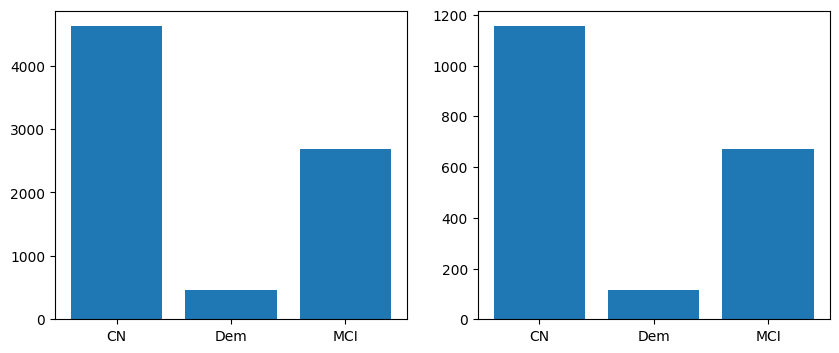

In [10]:
import seaborn as sns
fig, axes = plt.subplots(1,2, figsize=(10,4))
train_df=pd.Series(y_train).value_counts().reset_index()
val_df=pd.Series(y_val).value_counts().reset_index()

axes[0].bar(data=train_df, x='index', height='count')
axes[1].bar(data=val_df, x='index', height='count')
# plt.xticks(np.arange(0,3), ['CN', 'Dem', 'MCI'])
axes[0].set_xticks(np.arange(0,3), ['CN', 'Dem', 'MCI'])
axes[1].set_xticks(np.arange(0,3), ['CN', 'Dem', 'MCI'])
axes[0].set_xlabel('')
axes[1].set_xlabel('')
plt.show()

## Train and Evaluate Models

In [11]:
# 모델 학습 및 평가
models = {
    "Lasso Regression": LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr'),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "Support Vector Machine": SVC(kernel='linear', probability=True, random_state=random_seed),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed)
}

In [12]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted') # weighted: 불균형한 데이터에 가중치를 두어 계산.
    print(f"{name} Accuracy: {acc:.2f}")
    print(f"{name} F1-score: {f1:.2f}")
    print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))
    print("="*60)

Lasso Regression Accuracy: 0.64
Lasso Regression F1-score: 0.61
              precision    recall  f1-score   support

          CN       0.66      0.85      0.74      1156
         Dem       0.78      0.43      0.55       114
         MCI       0.55      0.31      0.39       671

    accuracy                           0.64      1941
   macro avg       0.66      0.53      0.56      1941
weighted avg       0.63      0.64      0.61      1941

Decision Tree Accuracy: 0.67
Decision Tree F1-score: 0.67
              precision    recall  f1-score   support

          CN       0.74      0.74      0.74      1156
         Dem       0.45      0.52      0.48       114
         MCI       0.58      0.56      0.57       671

    accuracy                           0.67      1941
   macro avg       0.59      0.61      0.60      1941
weighted avg       0.67      0.67      0.67      1941

Support Vector Machine Accuracy: 0.63
Support Vector Machine F1-score: 0.55
              precision    recall  f1-sc

## Evaluate Test data

In [13]:
X_test, y_test = merge_split(test_activity, test_sleep, test_label)
y_test = label_encoder.fit_transform(y_test)
X_test_scaled = scaler.transform(X_test)

X:(2478, 51)
y:(2478,)


In [14]:
y_test

array([0, 0, 0, ..., 0, 0, 0], shape=(2478,))

In [15]:
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.2f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("="*60)

Lasso Regression Accuracy: 0.68
              precision    recall  f1-score   support

          CN       0.79      0.82      0.80      1956
         Dem       0.82      0.23      0.36       214
         MCI       0.09      0.11      0.10       308

    accuracy                           0.68      2478
   macro avg       0.56      0.39      0.42      2478
weighted avg       0.70      0.68      0.68      2478

Decision Tree Accuracy: 0.56
              precision    recall  f1-score   support

          CN       0.81      0.62      0.70      1956
         Dem       0.40      0.29      0.34       214
         MCI       0.12      0.32      0.18       308

    accuracy                           0.56      2478
   macro avg       0.44      0.41      0.41      2478
weighted avg       0.69      0.56      0.61      2478

Support Vector Machine Accuracy: 0.76
              precision    recall  f1-score   support

          CN       0.80      0.93      0.86      1956
         Dem       0.86      0

# Case2 사람별 통계치 계산 후 분류

In [16]:
def statistic_person(data, features):
    data_summary = data.groupby('EMAIL')[features].agg(['mean', 'std']).reset_index()
    data_summary.columns = ['_'.join(col).strip('_') for col in data_summary.columns]
    return data_summary

In [17]:
act_features=train_activity.select_dtypes(include=[int, float]).columns
sleep_features=train_sleep.select_dtypes(include=[int, float]).columns

act_train=statistic_person(train_activity, act_features)
sleep_train=statistic_person(train_sleep, sleep_features)

In [18]:
X, y = merge_split(act_train, sleep_train, train_label)

X:(141, 102)
y:(141,)


In [19]:
X_scaled = scaler.fit_transform(X)
y=label_encoder.transform(y)

In [20]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=random_seed)

In [21]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted') # weighted: 불균형한 데이터에 가중치를 두어 계산.
    print(f"{name} Accuracy: {acc:.2f}")
    print(f"{name} F1-score: {f1:.2f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("="*60)

ValueError: Found input variables with inconsistent numbers of samples: [1941, 29]